Setup environment

In [1]:
# Ensure src folder is importable
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Auto-reload changes in .py files
# %load_ext autoreload
# %autoreload 2

Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from src.data.data_loader import CryptoDataLoader
from src.data.feature_engineering import FeatureEngineer
from src.models.transformer import TransformerModel

Load & prepare data

In [3]:
# Load BTC data
loader = CryptoDataLoader(data_dir="data/raw")
df = loader.load_saved_data("BTC-USD", "2024-01-01", "2025-01-01")


In [4]:
# Feature engineering
fe = FeatureEngineer()
df_features = fe.add_technical_indicators(df)


j:\Data Science\crypto_forecasting\venv\Lib\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
j:\Data Science\crypto_forecasting\venv\Lib\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [5]:
# Normalize and create sequences
normalized_data = fe.normalize_data(df_features)
sequence_length = 30
X, y = fe.create_sequences(df_features, sequence_length=sequence_length, target_col='Close')


In [6]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [7]:
print("Input shape:", X_tensor.shape)
print("Target shape:", y_tensor.shape)


Input shape: torch.Size([303, 30, 27])
Target shape: torch.Size([303, 1])


In [8]:
# Create DataLoader
batch_size = 32
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Initialize Transformer model

In [9]:
input_size = X_tensor.shape[2]  # number of features
d_model = 64
nhead = 4
num_encoder_layers = 2
dim_feedforward = 128
output_size = 1
dropout = 0.1


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [11]:
model = TransformerModel(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout
).to(device)

print(model)

TransformerModel(
  (input_projection): Linear(in_features=27, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Loss & optimizer

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training loop

In [13]:
num_epochs = 5  # for demo; increase for real training

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.6f}")


Epoch 1/5, Loss: nan
Epoch 2/5, Loss: nan
Epoch 3/5, Loss: nan
Epoch 4/5, Loss: nan
Epoch 5/5, Loss: nan


Inference and plotting

In [14]:
model.eval()
with torch.no_grad():
    predictions = model(X_tensor.to(device)).cpu().numpy()


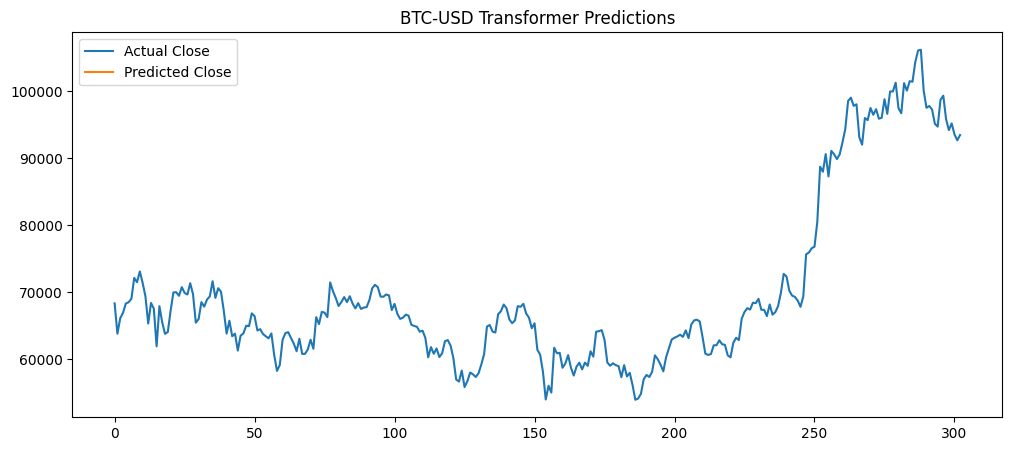

In [15]:

plt.figure(figsize=(12,5))
plt.plot(y, label='Actual Close')
plt.plot(predictions, label='Predicted Close')
plt.title("BTC-USD Transformer Predictions")
plt.legend()
plt.show()


save/load model

In [ ]:
torch.save(model.state_dict(), 'transformer.pth')
model.load_state_dict(torch.load('transformer.pth'))